# Integration of snRNA/ ATAC and scRNA data

In this notebook scATAC and scRNA data is integrated into one latent space. To construct a common latent space for both measurements we are using `scglue` in this notebook

**Requires:**
- `/vol/storage/data/pancreas_multiome/processed/atac_e15.5.h5ad`
- `/vol/storage/data/pancreas_sc/processed/gex_e15.5.h5ad`
- `/vol/storage/data/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz` (downloadable from ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz)

**Output:**
- `/vol/storage/data/pancreas_sc_multiome/atac_sc_rna_scglue`


## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from itertools import chain

import mplscience
import scglue

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc
import scvelo as scv

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR, PROJECT_DIR  # isort: skip  # noqa: E402

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/storage/miniconda3/envs/conda_env_robin/lib/pyt

## General settings

In [11]:
SAVE_FIGURES = True
SAVE_MODEL = False
SN_PROCESSED_DIR = PROJECT_DIR / "pancreas_multiome" / "processed"
SC_PROCESSED_DIR = PROJECT_DIR / "pancreas_sc" / "processed"

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

celltype_colors = {
    "celltype_colors": {
        "Alpha": "#1f78b4",
        "Beta": "#b2df8a",
        "Delta": "#6a3d9a",
        "Ductal": "#8fbc8f",
        "Epsilon": "#cab2d6",
        "Ngn3 high EP": "#fdbf6f",
        "Ngn3 low EP": "#f4a460",
        "Pre-endocrine": "#ff7f00",
    },
    "celltype_fine_colors": {
        "Alpha": "#1f78b4",
        "Beta": "#b2df8a",
        "Delta": "#6a3d9a",
        "Ductal": "#8fbc8f",
        "Eps/Delta progenitors": "#029e73",
        "Epsilon": "#cab2d6",
        "Ngn3 high EP": "#fdbf6f",
        "Ngn3 low EP": "#f4a460",
        "Fev+ Alpha": "#d55e00",
        "Fev+ Beta": "#cc78bc",
        "Fev+ Delta": "#ca9161",
    },
}

## Read Data

In [4]:
adata_atac = sc.read(SN_PROCESSED_DIR / "atac_e15.5.h5ad")
adata_sc = sc.read(SC_PROCESSED_DIR / "gex_e15.5.h5ad")

## Preprocess scRNA-seq data
Similarly to https://scglue.readthedocs.io/en/latest/preprocessing.html#Construct-prior-regulatory-graph

Extracted 2067 highly variable genes.


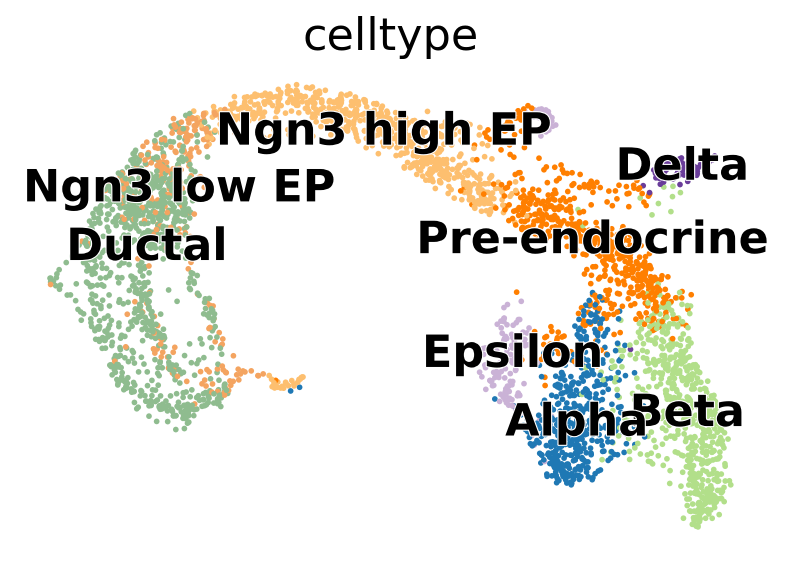

In [5]:
adata_sc.layers["counts"] = adata_sc.layers["spliced"] + adata_sc.layers["unspliced"]
adata_sc.X = adata_sc.layers["counts"]
scv.pp.filter_genes_dispersion(adata_sc)
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
sc.pp.scale(adata_sc)
sc.tl.pca(adata_sc, n_comps=100, svd_solver="auto")
sc.pp.neighbors(adata_sc, metric="cosine")
sc.tl.umap(adata_sc)

# adata_sc.uns["celltype_colors"] is removed by one function, add it here again
adata_sc.uns = celltype_colors
scv.pl.umap(adata_sc, color="celltype")

## Preprocess ATAC data
Similarly to https://scglue.readthedocs.io/en/latest/preprocessing.html#Construct-prior-regulatory-graph

In [6]:
# ATAC var_names are of structure "chrom:chromStart-chromEnd", extract information for regulatory graph
split = adata_atac.var_names.str.split(r"[:-]")
adata_atac.var["chrom"] = split.map(lambda x: "chr" + x[0])
adata_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
adata_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)

adata_atac.var_names = (
    split.map(lambda x: "chr" + x[0]) + ":" + split.map(lambda x: x[1]) + "-" + split.map(lambda x: x[2])
)

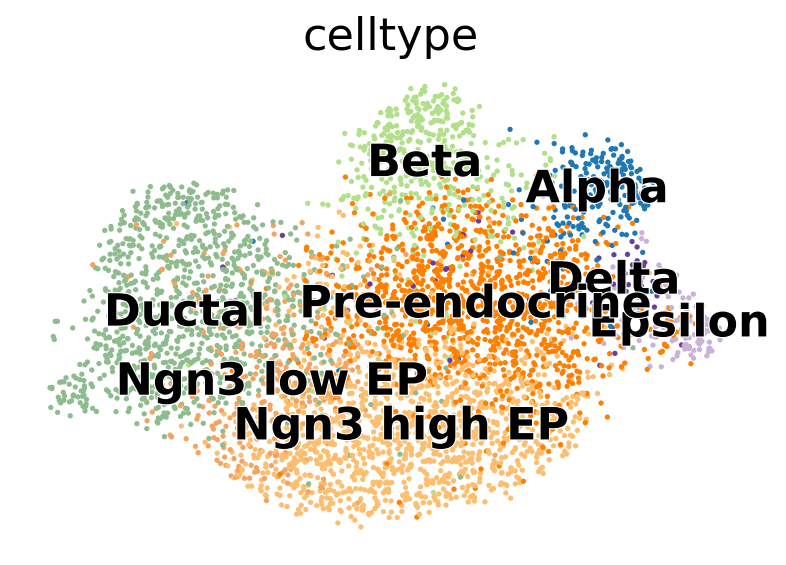

In [7]:
scglue.data.lsi(adata_atac, n_components=100, n_iter=15)
sc.pp.neighbors(adata_atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(adata_atac)
scv.pl.umap(adata_atac, color="celltype")

## Construct guidance graph for GLUE

In [8]:
# Add chromsone, start, end information to sc data with scglue
scglue.data.get_gene_annotation(
    adata_sc, gtf=PROJECT_DIR / "gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz", gtf_by="gene_name"
)

guidance = scglue.genomics.rna_anchored_guidance_graph(adata_sc, adata_atac)

# Run function to check graph
scglue.graph.check_graph(guidance, [adata_sc, adata_atac])

window_graph:   0%|          | 0/2067 [00:00<?, ?it/s]

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


## Configure data for scglue model training

In [9]:
scglue.models.configure_dataset(adata_sc, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_pca")
scglue.models.configure_dataset(adata_atac, "NB", use_highly_variable=True, use_rep="X_lsi")

guidance_hvf = guidance.subgraph(
    chain(adata_sc.var.query("highly_variable").index, adata_atac.var.query("highly_variable").index)
).copy()

## Train GLUE model

In [10]:
glue = scglue.models.fit_SCGLUE(
    {"sc_rna": adata_sc, "atac": adata_atac}, guidance_hvf, fit_kws={"directory": DATA_DIR / "glue_atac"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 35031
[INFO] SCGLUEModel: Setting `max_epochs` = 406
[INFO] SCGLUEModel: Setting `patience` = 34
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 17
[INFO] SCGLUETrainer: Using training directory: "/vol/storage/robin/code/nucleus_cytosol_velo_reproducibility_integration/data/glue_atac/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.523, 'g_kl': 0.003, 'g_elbo': 0.526, 'x_sc_rna_nll': 0.598, 'x_sc_rna_kl': 0.014, 'x_sc_rna_elbo': 0.612, 'x_atac_nll': 0.147, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.148, 'dsc_loss': 0.681, 'vae_loss': 0.781, 'gen_loss': 0.747}, val={'g_nll': 0.518, 'g_kl': 0.003, 'g_elbo': 0.521, 'x_sc_rna_nll': 0.6, 'x_sc_rna_kl

2023-10-10 13:56:37,037 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 14)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 35031
[INFO] SCGLUEModel: Setting `align_burnin` = 68
[INFO] SCGLUEModel: Setting `max_epochs` = 406
[INFO] SCGLUEModel: Setting `patience` = 34
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 17
[INFO] SCGLUETrainer: Using training directory: "/vol/storage/robin/code/nucleus_cytosol_velo_reproducibility_integratio

2023-10-10 14:06:27,156 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "121"...
[INFO] EarlyStopping: Restoring checkpoint "121"...


## Save model
Can be loaded with `glue = scglue.models.load_model("glue_atac.dill")`

In [12]:
if SAVE_MODEL:
    glue.save(DATA_DIR / "glue_atac.dill")

## Check integration diagnostics

In [13]:
# For the plot we need a column of dtype category, and to concat/ run integration_consistency, chrom needs to have same dtypes
adata_atac.obs["protocol"] = "ATAC"
adata_atac.obs["protocol"] = adata_atac.obs["protocol"].astype("category")
adata_sc.var["chrom"] = adata_sc.var["chrom"].astype("category")
adata_atac.var["chrom"] = adata_atac.var["chrom"].astype("category")

In [14]:
dx = scglue.models.integration_consistency(glue, {"sc_rna": adata_sc, "atac": adata_atac}, guidance_hvf)
dx

[INFO] integration_consistency: Using layer "counts" for modality "sc_rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "sc_rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "sc_rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 198 common metacells...


,n_meta,consistency
0,10,0.154873
1,20,0.147866
2,50,0.118711
3,100,0.099652
4,200,0.075674


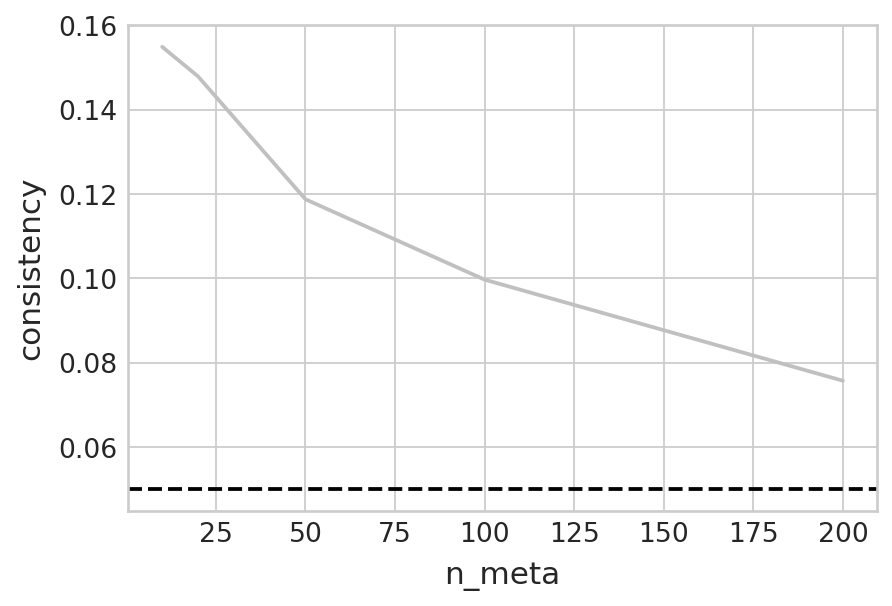

In [24]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.lineplot(x="n_meta", y="consistency", data=dx, color="silver").axhline(y=0.05, c="black", ls="--")
    plt.show()
    if SAVE_FIGURES:
        path = FIG_DIR / "integration"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "consistency_score_atac_e15.5.svg", format="svg", transparent=True, bbox_inches="tight")

## Get latent representation

In [ ]:
adata_sc.obsm["X_glue_atac"] = glue.encode_data("sc_rna", adata_sc)
adata_atac.obsm["X_glue_atac"] = glue.encode_data("atac", adata_atac)

## Plot UMAP of common latent space representation

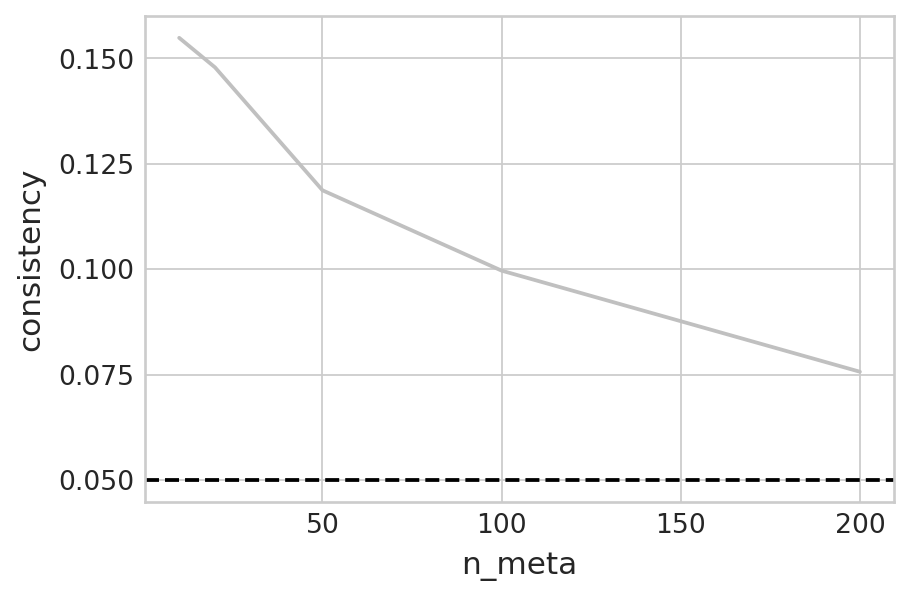

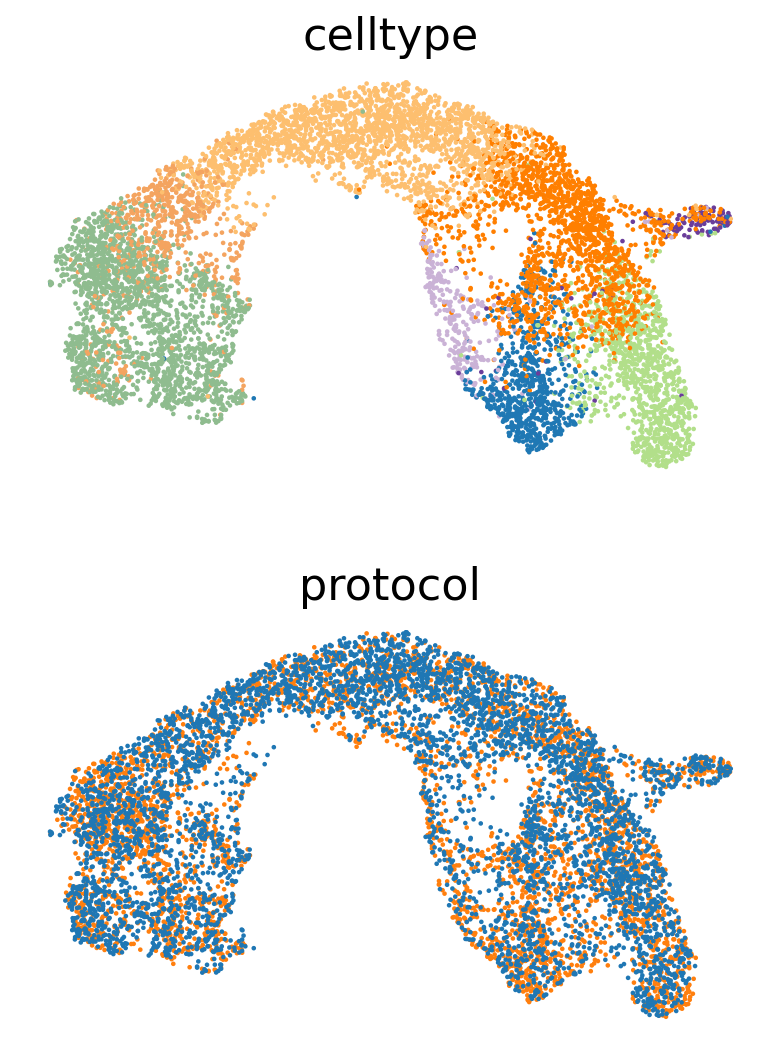

In [17]:
combined = ad.concat([adata_sc, adata_atac])
sc.pp.neighbors(combined, use_rep="X_glue_atac", metric="cosine")
sc.tl.umap(combined)

combined.uns["celltype_colors"] = celltype_colors["celltype_colors"]
scv.pl.umap(combined, color=["celltype", "protocol"], ncols=1)

## Estimate abundances
We perform estimation on raw counts (thus read in sn/ sc data once more)

In [18]:
adata_sn = sc.read(SN_PROCESSED_DIR / "gex_e15.5.h5ad")
adata_sc = sc.read(SC_PROCESSED_DIR / "gex_e15.5.h5ad")

adata = ad.concat([adata_sc, adata_sn])

# first filter highly variable genes with scanpy where we can specify a batch_key
adata.layers["counts"] = adata.layers["spliced"] + adata.layers["unspliced"]

scv.pp.filter_genes(adata, min_counts=20)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="protocol",
    subset=True,
)
adata

AnnData object with n_obs × n_vars = 8412 × 13255
    obs: 'day', 'celltype', 'n_counts', 'celltype_fine', 'protocol'
    layers: 'spliced', 'unspliced'

In [19]:
# Get neighbor graph
adata.obsm["X_glue_atac"] = combined[adata.obs_names, :].obsm["X_glue_atac"]
sc.pp.neighbors(adata, use_rep="X_glue_atac", metric="cosine")
scv.tl.umap(adata)

In [20]:
# adata object still has raw counts, no need to reload
adata = scv.pp.estimate_abundance(
    adata,
    layers=["unspliced", "spliced"],
    mode="connectivities",
    dataset_key="protocol",
    sc_rna_name="scRNA-seq",
    min_estimation_samples=1,
    smooth_obs=False,  # dont smooth because moments basically do the same afterwards
    clip_cyto=True,
    lambda_correction=True,
    filter_zero_genes=True,
)

After running fixed-point iteration, `8404/8412` observations remain
Removing `5.9289%` elements below 0


## Calculate Moments and Min-max scale

In [21]:
scv.pp.normalize_per_cell(
    adata,
    layers=["unspliced_nucleus", "spliced_nucleus", "spliced_cytoplasm", "spliced_cell"],
)
scv.pp.moments(
    adata,
    use_rep="X_glue_atac",
    layers={"unspliced_nucleus": "Mu_nuc", "spliced_nucleus": "Ms_nuc", "spliced_cytoplasm": "Ms_cyt"},
)

scaler = MinMaxScaler()
adata.layers["Mu_nuc"] = scaler.fit_transform(adata.layers["Mu_nuc"])

scaler = MinMaxScaler()
adata.layers["Ms_nuc"] = scaler.fit_transform(adata.layers["Ms_nuc"])

scaler = MinMaxScaler()
adata.layers["Ms_cyt"] = scaler.fit_transform(adata.layers["Ms_cyt"])

Filtered out 362 genes that are detected 20 counts (spliced).
Normalized count data: X, unspliced_nucleus, spliced_nucleus, spliced_cytoplasm, spliced_cell.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    ['Mu_nuc', 'Ms_nuc', 'Ms_cyt'] moments of un/spliced abundances (adata.layers)


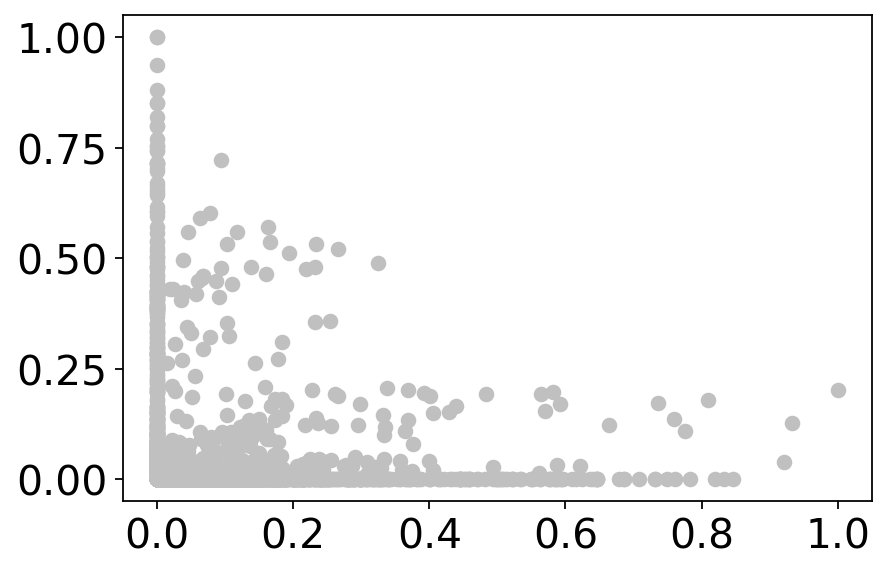

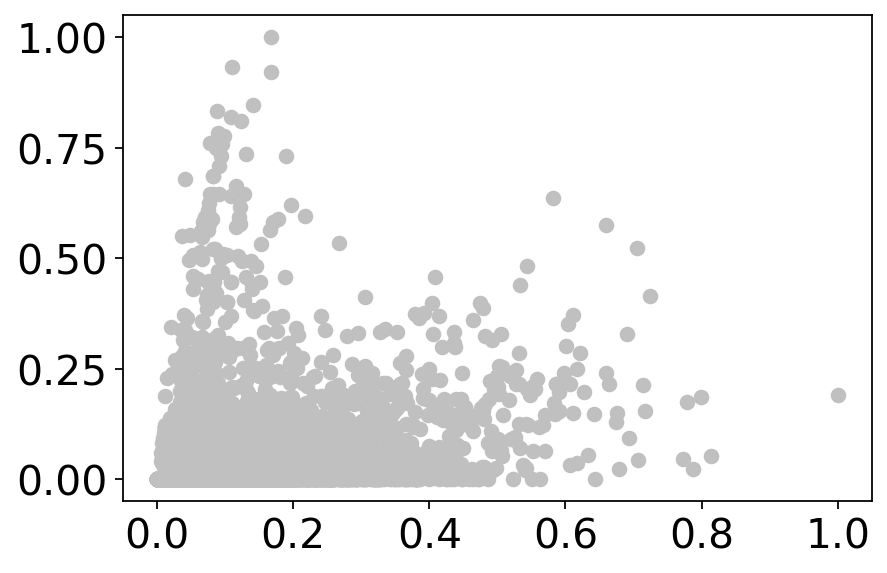

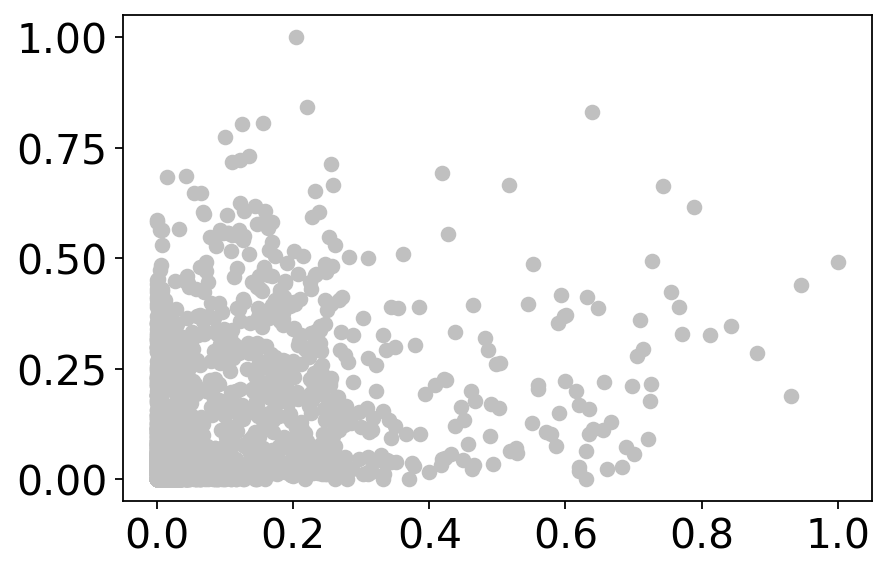

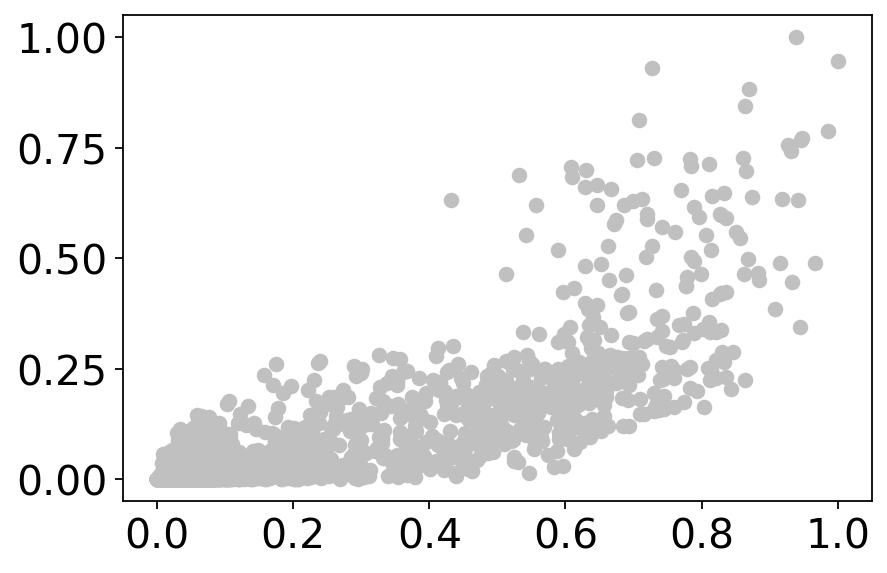

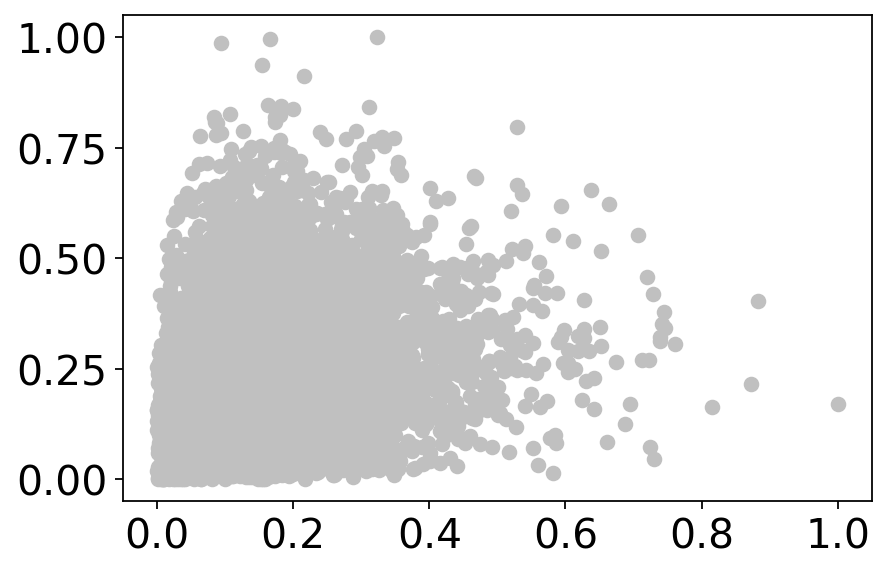

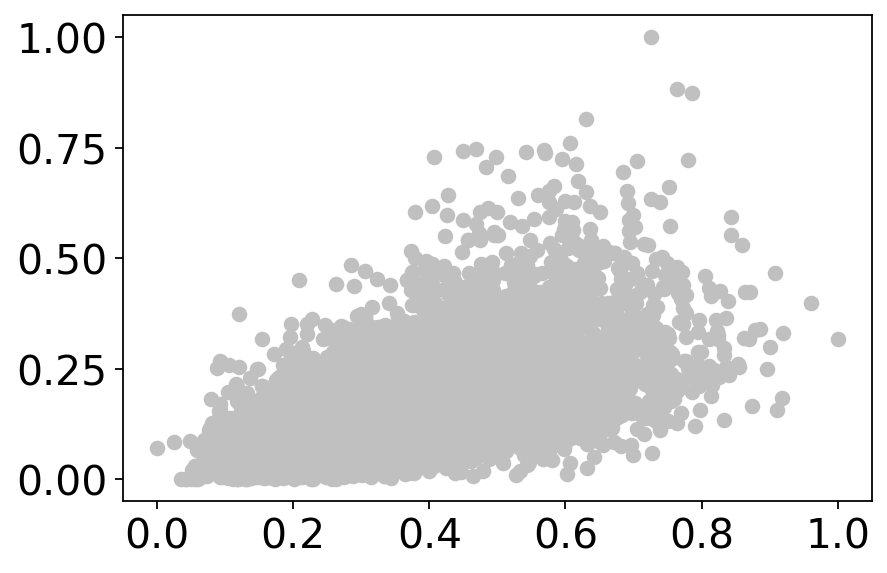

In [22]:
# Plot first 3 genes phase portraits to check if they look reasonable
for gene in range(3):
    plt.scatter(adata.layers["Ms_nuc"][:, gene], adata.layers["Ms_cyt"][:, gene], color="silver")
    plt.show()
    plt.scatter(adata.layers["Mu_nuc"][:, gene], adata.layers["Ms_nuc"][:, gene], color="silver")
    plt.show()

## Store result with latent representation

In [23]:
adata.write(PROJECT_DIR / "pancreas_sc_multiome" / "atac_sc_rna_scglue_e15.5.h5ad")